# Предварительная подготовка данных для построения модели на обучающей выборке - части исторической выборки

In [1]:
# для работы с программным кодом R в Jupiter,
# запустите Anaconda Prompt и установите 
# пакет r-essentials с помощью строки 
# conda install r-essentials

# подключаем пакеты
library(dplyr)
library(caret)
library(imputeMissings)
library(Hmisc)
library(rcompanion)
library(car)

Warning message:
"package 'dplyr' was built under R version 3.4.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: lattice
Loading required package: ggplot2
Warning message:
"package 'imputeMissings' was built under R version 3.4.3"
Attaching package: 'imputeMissings'

The following object is masked from 'package:dplyr':

    compute

Warning message:
"package 'Hmisc' was built under R version 3.4.3"Loading required package: survival

Attaching package: 'survival'

The following object is masked from 'package:caret':

    cluster

Loading required package: Formula

Attaching package: 'Hmisc'

The following object is masked from 'package:imputeMissings':

    impute

The following objects are masked from 'package:dplyr':

    src, summarize

The following objects are masked from 'package:base':

    format.pval, un

In [2]:
# создаем рабочее пространство с файлами выборки
setwd("C:/Trees")

In [3]:
# загружаем данные
OTPset <- read.csv2("Credit_OTP.csv", stringsAsFactors = F)
OTPset_test <- read.csv2("Credit_OTP_new.csv", stringsAsFactors = F)

In [4]:
# смотрим количество уникальных значений у AGREEMENT_RK 
length(unique(OTPset$AGREEMENT_RK))

[1] 15223

In [5]:
# удаляем переменную AGREEMENT_RK
OTPset$AGREEMENT_RK <- NULL

In [6]:
# смотрим типы переменных
str(OTPset)

'data.frame':	15223 obs. of  51 variables:
 $ TARGET                    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ AGE                       : int  49 32 52 39 30 29 35 41 53 43 ...
 $ SOCSTATUS_WORK_FL         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ SOCSTATUS_PENS_FL         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ GENDER                    : int  1 1 1 1 0 0 0 1 0 1 ...
 $ CHILD_TOTAL               : int  2 3 4 1 0 0 1 0 2 0 ...
 $ DEPENDANTS                : int  1 3 0 1 0 0 1 0 0 0 ...
 $ EDUCATION                 : chr  "Среднее специальное" "Среднее" "Неполное среднее" "Высшее" ...
 $ MARITAL_STATUS            : chr  "Состою в браке" "Состою в браке" "Состою в браке" "Состою в браке" ...
 $ GEN_INDUSTRY              : chr  "Торговля" "Торговля" "Информационные технологии" "Образование" ...
 $ GEN_TITLE                 : chr  "Рабочий" "Рабочий" "Специалист" "Руководитель среднего звена" ...
 $ ORG_TP_STATE              : chr  "Частная компания" "Индивидуальный предприниматель" "Государственная комп./у

## Написание и применение функций для преобразования типов переменных

In [7]:
# пишем функцию для проставления метки "Не указано"
nonInformation <- 
  function(variable) {
    variable <- ifelse(variable == "" | variable == "Пропуск", "Не указано", 
                       variable)
    return(variable)
  }

In [8]:
# пишем функцию предобработки для приведения переменных к нужному формату, 
# удаления переменной с одним уникальным значением,
# создания переменной на соответствие адресов
preProcessData <- 
  function(data) {
    data <- 
      data %>%
      dplyr::mutate(
        TARGET = factor(TARGET, levels = c(0,1), labels = c("noResponse", "Response")),
        SOCSTATUS_WORK_FL = as.factor(SOCSTATUS_WORK_FL),
        SOCSTATUS_PENS_FL = as.factor(SOCSTATUS_PENS_FL),
        GENDER = as.factor(GENDER),
        MARITAL_STATUS = as.factor(MARITAL_STATUS),
        FAMILY_INCOME = as.numeric(as.factor(FAMILY_INCOME)),
        GEN_INDUSTRY = ifelse(GEN_INDUSTRY == "" & SOCSTATUS_PENS_FL == 1,
                              "Пенсия", GEN_INDUSTRY),
        GEN_INDUSTRY = nonInformation(GEN_INDUSTRY),
        GEN_TITLE = ifelse(GEN_TITLE == "" & SOCSTATUS_PENS_FL == 1,
                           "Пенсия", GEN_TITLE),
        GEN_TITLE = nonInformation(GEN_TITLE),
        ORG_TP_STATE = ifelse(ORG_TP_STATE == "" & SOCSTATUS_PENS_FL == 1,
                              "Пенсия", ORG_TP_STATE),
        ORG_TP_STATE = nonInformation(ORG_TP_STATE),
        ORG_TP_FCAPITAL = ifelse(ORG_TP_FCAPITAL == "" & SOCSTATUS_PENS_FL == 1,
                                 "Пенсия", ORG_TP_FCAPITAL),
        ORG_TP_FCAPITAL = nonInformation(ORG_TP_FCAPITAL),
        JOB_DIR = ifelse(JOB_DIR == "" & SOCSTATUS_PENS_FL == 1,
                         "Пенсия", JOB_DIR),
        JOB_DIR = nonInformation(JOB_DIR),
        TP_PROVINCE = nonInformation(TP_PROVINCE),
        REGION_NM = nonInformation(REGION_NM),
        REGION_NM = ifelse(REGION_NM == "ПОВОЛЖСКИЙ", "ПРИВОЛЖСКИЙ", REGION_NM),  
        REG_FACT_FL = as.factor(REG_FACT_FL),
        FACT_POST_FL = as.factor(FACT_POST_FL),
        REG_POST_FL = as.factor(REG_POST_FL),
        REG_FACT_POST_FL = as.factor(REG_FACT_POST_FL),
        FL_PRESENCE_FL = as.factor(FL_PRESENCE_FL),
        AUTO_RUS_FL = as.factor(AUTO_RUS_FL),
        HS_PRESENCE_FL = as.factor(HS_PRESENCE_FL),
        COT_PRESENCE_FL = as.factor(COT_PRESENCE_FL),
        GAR_PRESENCE_FL = as.factor(GAR_PRESENCE_FL),
        LAND_PRESENCE_FL = as.factor(LAND_PRESENCE_FL),
        DL_DOCUMENT_FL = NULL,
        GPF_DOCUMENT_FL = as.factor(GPF_DOCUMENT_FL),
        FACT_PHONE_FL = as.factor(FACT_PHONE_FL),
        REG_PHONE_FL = as.factor(REG_PHONE_FL),
        GEN_PHONE_FL = as.factor(GEN_PHONE_FL),
        PREVIOUS_CARD_NUM_UTILIZED =
          ifelse(is.na(PREVIOUS_CARD_NUM_UTILIZED), 0, PREVIOUS_CARD_NUM_UTILIZED),
        # факт совпадения фактического области проживания и торговой точки
        FACT_TP_FL = as.factor(ifelse(FACT_ADDRESS_PROVINCE == TP_PROVINCE, 1, 0))
      )
    return(data)
  }

In [9]:
# пишем функцию предобработки для тестового набора
preProcessDataTest <- 
  function(data) {
    data <- 
      data %>%
      dplyr::mutate(
        TARGET = factor(TARGET, levels = c(0,1), labels = c("noResponse", "Response")),
        SOCSTATUS_WORK_FL = as.factor(SOCSTATUS_WORK_FL),
        SOCSTATUS_PENS_FL = as.factor(SOCSTATUS_PENS_FL),
        GENDER = as.factor(GENDER),
        MARITAL_STATUS = as.factor(MARITAL_STATUS),
        FAMILY_INCOME = as.numeric(as.factor(FAMILY_INCOME)),
        GEN_INDUSTRY = ifelse(GEN_INDUSTRY == "Пропуск" & SOCSTATUS_PENS_FL == 1,
                              "Пенсия", GEN_INDUSTRY),
        GEN_INDUSTRY = nonInformation(GEN_INDUSTRY),
        GEN_TITLE = ifelse(GEN_TITLE == "Пропуск" & SOCSTATUS_PENS_FL == 1,
                           "Пенсия", GEN_TITLE),
        GEN_TITLE = nonInformation(GEN_TITLE),
        ORG_TP_STATE = ifelse(ORG_TP_STATE == "Пропуск" & SOCSTATUS_PENS_FL == 1,
                              "Пенсия", ORG_TP_STATE),
        ORG_TP_STATE = nonInformation(ORG_TP_STATE),
        ORG_TP_FCAPITAL = ifelse(ORG_TP_FCAPITAL == "Пропуск" & SOCSTATUS_PENS_FL == 1,
                                 "Пенсия", ORG_TP_FCAPITAL),
        ORG_TP_FCAPITAL = nonInformation(ORG_TP_FCAPITAL),
        JOB_DIR = ifelse(JOB_DIR == "Пропуск" & SOCSTATUS_PENS_FL == 1,
                         "Пенсия", JOB_DIR),
        JOB_DIR = nonInformation(JOB_DIR),
        TP_PROVINCE = nonInformation(TP_PROVINCE),
        REGION_NM = nonInformation(REGION_NM),
        REG_FACT_FL = as.factor(REG_FACT_FL),
        FACT_POST_FL = as.factor(FACT_POST_FL),
        REG_POST_FL = as.factor(REG_POST_FL),
        REG_FACT_POST_FL = as.factor(REG_FACT_POST_FL),
        FL_PRESENCE_FL = as.factor(FL_PRESENCE_FL),
        AUTO_RUS_FL = as.factor(AUTO_RUS_FL),
        HS_PRESENCE_FL = as.factor(HS_PRESENCE_FL),
        COT_PRESENCE_FL = as.factor(COT_PRESENCE_FL),
        GAR_PRESENCE_FL = as.factor(GAR_PRESENCE_FL),
        LAND_PRESENCE_FL = as.factor(LAND_PRESENCE_FL),
        DL_DOCUMENT_FL = NULL,
        GPF_DOCUMENT_FL = as.factor(GPF_DOCUMENT_FL),
        FACT_PHONE_FL = as.factor(FACT_PHONE_FL),
        REG_PHONE_FL = as.factor(REG_PHONE_FL),
        GEN_PHONE_FL = as.factor(GEN_PHONE_FL),
        PREVIOUS_CARD_NUM_UTILIZED =
          ifelse(is.na(PREVIOUS_CARD_NUM_UTILIZED), 0, PREVIOUS_CARD_NUM_UTILIZED),
        # факт совпадения фактического области проживания и торговой точки
        FACT_TP_FL = as.factor(ifelse(FACT_ADDRESS_PROVINCE == TP_PROVINCE, 1, 0))
      )
    return(data)
  }

In [10]:
# применяем функции предобработки
# к набору данных
OTPset <- preProcessData(OTPset)

In [11]:
# выводим подробную информацию
# о переменных
Hmisc::describe(OTPset)

OTPset 

 51  Variables      15223  Observations
--------------------------------------------------------------------------------
TARGET 
       n  missing distinct 
   15223        0        2 
                                
Value      noResponse   Response
Frequency       13411       1812
Proportion      0.881      0.119
--------------------------------------------------------------------------------
AGE 
       n  missing distinct     Info     Mean      Gmd      .05      .10 
   15223        0       47    0.999    40.41    13.34       24       25 
     .25      .50      .75      .90      .95 
      30       39       50       57       60 

lowest : 21 22 23 24 25, highest: 63 64 65 66 67
--------------------------------------------------------------------------------
SOCSTATUS_WORK_FL 
       n  missing distinct 
   15223        0        2 
                      
Value          0     1
Frequency   1376 13847
Proportion  0.09  0.91
----------------------------------------------------

## Разбиение исторической выборки на обучающую и тестовую

In [12]:
# разбиваем на обучающую и тестовую выборки
set.seed(45151)
index = createDataPartition(OTPset$TARGET, p = 0.7, list = F)
training <- OTPset[index,]
testing <- OTPset[-index,]

In [13]:
# пишем функцию для анализа редких категорий
freqTable <- 
  function(variable) {
    FreqTable <- data.frame(table(variable))
    FreqTable <- 
      FreqTable %>% 
      mutate(Share = Freq/sum(Freq)) %>%
      arrange(desc(Share)) %>%
      mutate(Cumshare = cumsum(Share))
    return(FreqTable)
  }

## Анализ частот категорий по переменным

In [14]:
# выводим обычные и накопленные доли 
# категорий переменной GEN_INDUSTRY, с помощью 
# options(scipen=999) отключаем 
# экспоненциальное представление чисел
options(scipen=999)
FreqGEN_INDUSTRY <- freqTable(training$GEN_INDUSTRY)
FreqGEN_INDUSTRY

variable,Freq,Share,Cumshare
Торговля,1644,0.15426480248,0.1542648
Другие сферы,1193,0.11194520034,0.2662100
Пенсия,954,0.08951862626,0.3557286
Металлургия/Промышленность/Машиностроение,922,0.08651590504,0.4422445
Государственная служба,917,0.08604672985,0.5282913
Здравоохранение,839,0.07872759688,0.6070189
Образование,719,0.06746739232,0.6744863
Транспорт,531,0.04982640518,0.7243127
Сельское хозяйство,491,0.04607300366,0.7703857
Строительство,414,0.03884770573,0.8092334


In [15]:
# выводим частоты категорий переменной GEN_TITLE
table(training$GEN_TITLE)


   Военнослужащий по контракту     Высококвалифиц. специалист 
                            65                            397 
                        Другое Индивидуальный предприниматель 
                           126                            158 
                    Не указано                        Партнер 
                             1                              8 
                        Пенсия           Работник сферы услуг 
                           954                            404 
                       Рабочий     Руководитель высшего звена 
                          2166                            308 
    Руководитель низшего звена    Руководитель среднего звена 
                           103                            479 
                      Служащий                     Специалист 
                           629                           4859 

In [16]:
# выводим обычные и накопленные доли 
# категорий переменной GEN_TITLE
FreqGEN_TITLE <- freqTable(training$GEN_TITLE)
FreqGEN_TITLE

variable,Freq,Share,Cumshare
Специалист,4859,0.45594444966,0.4559444
Рабочий,2166,0.20324669231,0.6591911
Пенсия,954,0.08951862626,0.7487098
Служащий,629,0.05902223890,0.8077320
Руководитель среднего звена,479,0.04494698320,0.8526790
Работник сферы услуг,404,0.03790935535,0.8905883
Высококвалифиц. специалист,397,0.03725251009,0.9278409
Руководитель высшего звена,308,0.02890119170,0.9567420
Индивидуальный предприниматель,158,0.01482593600,0.9715680
Другое,126,0.01182321479,0.9833912


In [17]:
# смотрим средний личный доход в каждой
# категории переменной GEN_TITLE
training %>% group_by(GEN_TITLE) %>%
  summarise(PERSONAL_INCOME = mean(PERSONAL_INCOME))

GEN_TITLE,PERSONAL_INCOME
Военнослужащий по контракту,20938.462
Высококвалифиц. специалист,19066.247
Другое,12823.810
Индивидуальный предприниматель,19232.278
Не указано,10000.000
Партнер,20075.000
Пенсия,8317.948
Работник сферы услуг,12395.446
Рабочий,12320.485
Руководитель высшего звена,24026.948


In [18]:
# выводим частоты категорий переменной ORG_TP_STATE
table(training$ORG_TP_STATE)


  Государственная комп./учреж. Индивидуальный предприниматель 
                          4322                            665 
                    Не указано     Некоммерческая организация 
                             1                            167 
                        Пенсия Частная ком. с инос. капиталом 
                           954                             14 
              Частная компания 
                          4534 

In [19]:
# выводим частоты категорий переменной REG_ADDRESS_PROVINCE
table(training$REG_ADDRESS_PROVINCE)


      Агинский Бурятский АО                      Адыгея 
                          2                          93 
             Алтайский край            Амурская область 
                        329                         126 
      Архангельская область        Астраханская область 
                        182                          91 
                   Башкирия        Белгородская область 
                        156                         139 
           Брянская область                     Бурятия 
                        119                         132 
       Владимирская область       Волгоградская область 
                        120                         235 
        Вологодская область         Воронежская область 
                        207                         205 
               Горный Алтай                    Дагестан 
                         48                           2 
               Еврейская АО          Ивановская область 
                         46   

In [20]:
# выводим обычные и накопленные доли 
# категорий переменной REG_ADDRESS_PROVINCE
FreqREG_ADDRESS_PROVINCE <- freqTable(training$REG_ADDRESS_PROVINCE)
FreqREG_ADDRESS_PROVINCE

variable,Freq,Share,Cumshare
Кемеровская область,477,0.04475931,0.04475931
Краснодарский край,455,0.04269494,0.08745426
Алтайский край,329,0.03087173,0.11832598
Приморский край,305,0.02861969,0.14694567
Читинская область,304,0.02852585,0.17547152
Ростовская область,283,0.02655532,0.20202684
Свердловская область,253,0.02374026,0.22576710
Волгоградская область,235,0.02205123,0.24781834
Саратовская область,215,0.02017453,0.26799287
Татарстан,214,0.02008070,0.28807357


In [21]:
# выводим частоты категорий переменной FACT_ADDRESS_PROVINCE
table(training$FACT_ADDRESS_PROVINCE)


      Агинский Бурятский АО                      Адыгея 
                          2                          94 
             Алтайский край            Амурская область 
                        327                         125 
      Архангельская область        Астраханская область 
                        181                          89 
                   Башкирия        Белгородская область 
                        156                         137 
           Брянская область                     Бурятия 
                        118                         131 
       Владимирская область       Волгоградская область 
                        118                         236 
        Вологодская область         Воронежская область 
                        207                         206 
               Горный Алтай                Еврейская АО 
                         48                          48 
         Ивановская область           Иркутская область 
                        117   

In [22]:
# выводим частоты категорий переменной POSTAL_ADDRESS_PROVINCE
table(training$POSTAL_ADDRESS_PROVINCE)


      Агинский Бурятский АО                      Адыгея 
                          2                          93 
             Алтайский край            Амурская область 
                        328                         125 
      Архангельская область        Астраханская область 
                        181                          90 
                   Башкирия        Белгородская область 
                        156                         136 
           Брянская область                     Бурятия 
                        118                         131 
       Владимирская область       Волгоградская область 
                        118                         235 
        Вологодская область         Воронежская область 
                        208                         206 
               Горный Алтай                Еврейская АО 
                         48                          48 
         Ивановская область           Иркутская область 
                        117   

In [23]:
# выводим частоты категорий переменной TP_PROVINCE
table(training$TP_PROVINCE)


                 Адыгея          Алтайский край        Амурская область 
                     67                     316                     152 
  Архангельская область    Астраханская область                Башкирия 
                    172                      89                     110 
   Белгородская область        Брянская область                 Бурятия 
                    136                     121                     145 
   Владимирская область   Волгоградская область     Вологодская область 
                    118                     240                     207 
    Воронежская область            Горный Алтай            Еврейская АО 
                    213                      52                      47 
     Ивановская область       Иркутская область      Кабардино-Балкария 
                    117                     138                       8 
Калининградская область       Калужская область      Камчатская область 
                    104                      87   

In [24]:
# выводим обычные и накопленные доли 
# категорий переменной TP_PROVINCE
FreqTP_PROVINCE <- freqTable(training$TP_PROVINCE)
FreqTP_PROVINCE

variable,Freq,Share,Cumshare
Краснодарский край,540,0.05067092,0.05067092
Кемеровская область,473,0.04438397,0.09505489
Алтайский край,316,0.02965187,0.12470677
Приморский край,302,0.02833818,0.15304495
Ставропольский край,297,0.02786901,0.18091395
Читинская область,292,0.02739983,0.20831378
Ростовская область,283,0.02655532,0.23486910
Челябинская область,255,0.02392793,0.25879703
Свердловская область,248,0.02327109,0.28206812
Волгоградская область,240,0.02252041,0.30458853


In [25]:
# выводим частоты категорий переменной JOB_DIR
table(training$JOB_DIR)


    Адм-хоз. и трансп. службы Бухгалтерия, финансы, планир. 
                          189                           353 
  Вспомогательный техперсонал Кадровая служба и секретариат 
                          728                            70 
                   Не указано                        Пенсия 
                            1                           954 
   Пр-техн. обесп. и телеком.           Реклама и маркетинг 
                           48                             5 
          Служба безопасности              Снабжение и сбыт 
                          121                           158 
Участие в основ. деятельности            Юридическая служба 
                         7993                            37 

In [26]:
# выводим обычные и накопленные доли 
# категорий переменной JOB_DIR
FreqJOB_DIR <- freqTable(training$JOB_DIR) 

In [27]:
# выводим частоты категорий переменной REGION_NM
table(training$REGION_NM)


ВОСТОЧНО-СИБИРСКИЙ    ДАЛЬНЕВОСТОЧНЫЙ  ЗАПАДНО-СИБИРСКИЙ         Не указано 
               899                813               1288                  1 
       ПРИВОЛЖСКИЙ    СЕВЕРО-ЗАПАДНЫЙ          УРАЛЬСКИЙ      ЦЕНТРАЛЬНЫЙ 1 
              1885                712                846               1135 
     ЦЕНТРАЛЬНЫЙ 2   ЦЕНТРАЛЬНЫЙ ОФИС              ЮЖНЫЙ 
              1339                215               1524 

## Написание и применение функций для укрупнения редких категорий 

In [28]:
# пишем функцию по укрупнению "редких" регионов
replaceRareRegion <- 
  function(region) {
    region = ifelse(region == "Москва" | region == "Хакасия" |
                      region == "Ямало-Ненецкий АО" | region == "Магаданская область" |
                      region == "Калмыкия" | region == "Дагестан" |
                      region == "Агинский Бурятский АО" | 
                      region == "Усть-Ордынский Бурятский АО" |
                      region == "Эвенкийский АО" | region == "Коми-Пермяцкий АО" |
                      region == "Коми-Пермяцкий АО" | region == "Чечня", 
                    "Другие регионы",
                    region)
    region = as.factor(region)
    return(region)
  }

In [29]:
# пишем функцию по укрупнению редких категорий
replaceRareClass <- 
  function(data) {
    data <- 
      data %>%
      dplyr::mutate(
        EDUCATION = 
          as.factor(
            ifelse(EDUCATION == "Ученая степень" | 
                     EDUCATION == "Два и более высших образования" |
                     EDUCATION == "Высшее",
                   "Высшее или несколько высших", EDUCATION)
          ),
        GEN_INDUSTRY = 
          as.factor(
            ifelse(GEN_INDUSTRY == "Юридические услуги/нотариальные услуги" | 
                     GEN_INDUSTRY == "Страхование" |
                     GEN_INDUSTRY == "Туризм" |
                     GEN_INDUSTRY == "Недвижимость" |
                     GEN_INDUSTRY == "Управляющая компания" |
                     GEN_INDUSTRY == "Логистика" |
                     GEN_INDUSTRY == "Подбор персонала" |
                     GEN_INDUSTRY == "Маркетинг" |
                     GEN_INDUSTRY == "Не указано", "Другие сферы", GEN_INDUSTRY)
          ),
        GEN_TITLE = as.factor(
          ifelse(GEN_TITLE == "Партнер" | GEN_TITLE == "Не указано" |
                   GEN_TITLE == "Военнослужащий по контракту", 
                 "Другое", GEN_TITLE)
        ),
        ORG_TP_STATE = as.factor(
          ifelse(ORG_TP_STATE == "Частная ком. с инос. капиталом" |
                   ORG_TP_STATE == "Не указано",
                 "Частная компания", ORG_TP_STATE)
        ),
        ORG_TP_FCAPITAL = as.factor(
          ifelse(ORG_TP_FCAPITAL == "Не указано", "Без участия", ORG_TP_FCAPITAL)
        ),
        JOB_DIR = 
          as.factor(ifelse(JOB_DIR == "Кадровая служба и секретариат" |
                             JOB_DIR == "Пр-техн. обесп. и телеком." |
                             JOB_DIR == "Юридическая служба" |
                             JOB_DIR == "Реклама и маркетинг" |
                             JOB_DIR == "Не указано",
                           "Другие направления", JOB_DIR)),
        REGION_NM =
          as.factor(ifelse(REGION_NM == "Не указано", "ЮЖНЫЙ", REGION_NM)),
        REG_ADDRESS_PROVINCE = replaceRareRegion(REG_ADDRESS_PROVINCE),
        FACT_ADDRESS_PROVINCE = replaceRareRegion(FACT_ADDRESS_PROVINCE),
        POSTAL_ADDRESS_PROVINCE = replaceRareRegion(POSTAL_ADDRESS_PROVINCE),
        TP_PROVINCE = as.factor(
          ifelse(TP_PROVINCE == "Сахалинская область" | TP_PROVINCE == "Еврейская АО" |
                   TP_PROVINCE == "Магаданская область" | 
                   TP_PROVINCE == "Москва" |
                   TP_PROVINCE == "Кабардино-Балкария" |
                   TP_PROVINCE == "1", "Другие регионы", TP_PROVINCE)
        )
      )
    return(data)
  }


In [30]:
# применяем функцию, укрупняющую редкие
# категории, к обучающей выборке
training <- replaceRareClass(training)

## Написание и применение функций для обработки выбросов

In [31]:
# пишем функцию, обрабатывающую выбросы
replaceOutlier <- 
  function(data) {
    data <- 
      data %>% mutate(
        FACT_LIVING_TERM = 
          ifelse(FACT_LIVING_TERM < 0, abs(FACT_LIVING_TERM), FACT_LIVING_TERM),
        FACT_LIVING_TERM = 
          ifelse(FACT_LIVING_TERM > quantile(FACT_LIVING_TERM, 0.999), NA, 
                 FACT_LIVING_TERM),
        WORK_TIME = 
          ifelse(WORK_TIME > quantile(WORK_TIME, 0.999, na.rm = T), NA, WORK_TIME)
      )
    return(data)
  }

In [32]:
# применяем функцию, обрабатывающую выбросы,
# к обучающей выборке
training <- replaceOutlier(training)

In [33]:
# смотрим количество пропусков по каждой переменной
# в обучающей выборке
print(sapply(training, function(x) sum(is.na(x))))

                    TARGET                        AGE 
                         0                          0 
         SOCSTATUS_WORK_FL          SOCSTATUS_PENS_FL 
                         0                          0 
                    GENDER                CHILD_TOTAL 
                         0                          0 
                DEPENDANTS                  EDUCATION 
                         0                          0 
            MARITAL_STATUS               GEN_INDUSTRY 
                         0                          0 
                 GEN_TITLE               ORG_TP_STATE 
                         0                          0 
           ORG_TP_FCAPITAL                    JOB_DIR 
                         0                          0 
             FAMILY_INCOME            PERSONAL_INCOME 
                         0                          0 
      REG_ADDRESS_PROVINCE      FACT_ADDRESS_PROVINCE 
                         0                          0 
   POSTAL_

In [34]:
# импутируем пропуски в количественных 
# переменных медианами
training[sapply(training, is.numeric)] <- lapply(training[sapply(training, is.numeric)], 
                                                 function(x) 
                                                     ifelse(is.na(x),
                                                            median(x, na.rm = TRUE), x))

In [35]:
# смотрим количество пропусков по каждой переменной
# в обучающей выборке
print(sapply(training, function(x) sum(is.na(x))))

                    TARGET                        AGE 
                         0                          0 
         SOCSTATUS_WORK_FL          SOCSTATUS_PENS_FL 
                         0                          0 
                    GENDER                CHILD_TOTAL 
                         0                          0 
                DEPENDANTS                  EDUCATION 
                         0                          0 
            MARITAL_STATUS               GEN_INDUSTRY 
                         0                          0 
                 GEN_TITLE               ORG_TP_STATE 
                         0                          0 
           ORG_TP_FCAPITAL                    JOB_DIR 
                         0                          0 
             FAMILY_INCOME            PERSONAL_INCOME 
                         0                          0 
      REG_ADDRESS_PROVINCE      FACT_ADDRESS_PROVINCE 
                         0                          0 
   POSTAL_

## Поиск преобразований, максимизирующих нормальность распределения (сокращенно)

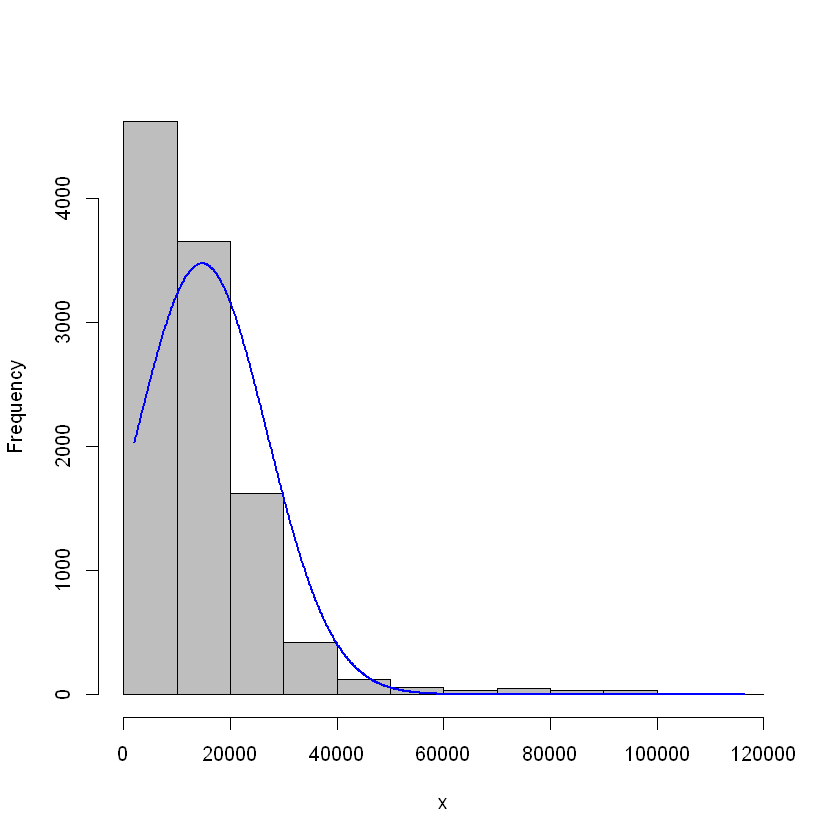

In [36]:
# выводим гистограмму распределения для переменной CREDIT 
# с помощью функции plotNormalHistogram пакета rcompanion
plotNormalHistogram(training$CREDIT)

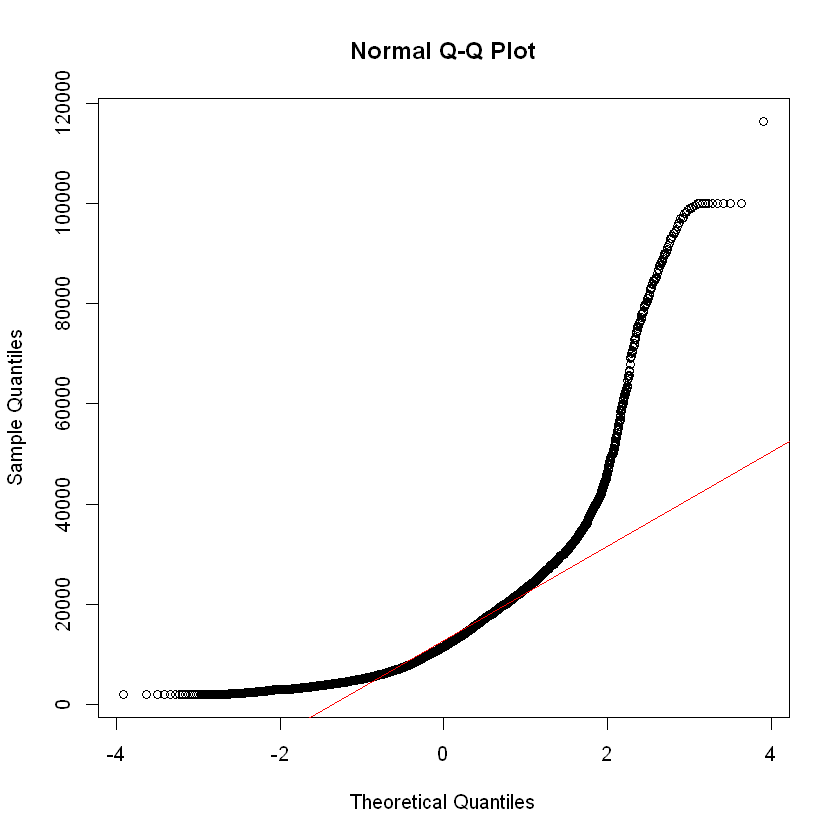

In [37]:
# выводим график квантиль-квантиль для переменной CREDIT
# с помощью функций qqnorm и qqline
qqnorm(training$CREDIT,
       ylab="Sample Quantiles")
qqline(training$CREDIT, 
       col="red")

In [38]:
# выполняем логарифмическое преобразование переменной
# CREDIT, используем константу 0.01, чтобы не брать
# логарифм нуля
var_log = log(training$CREDIT+0.01)

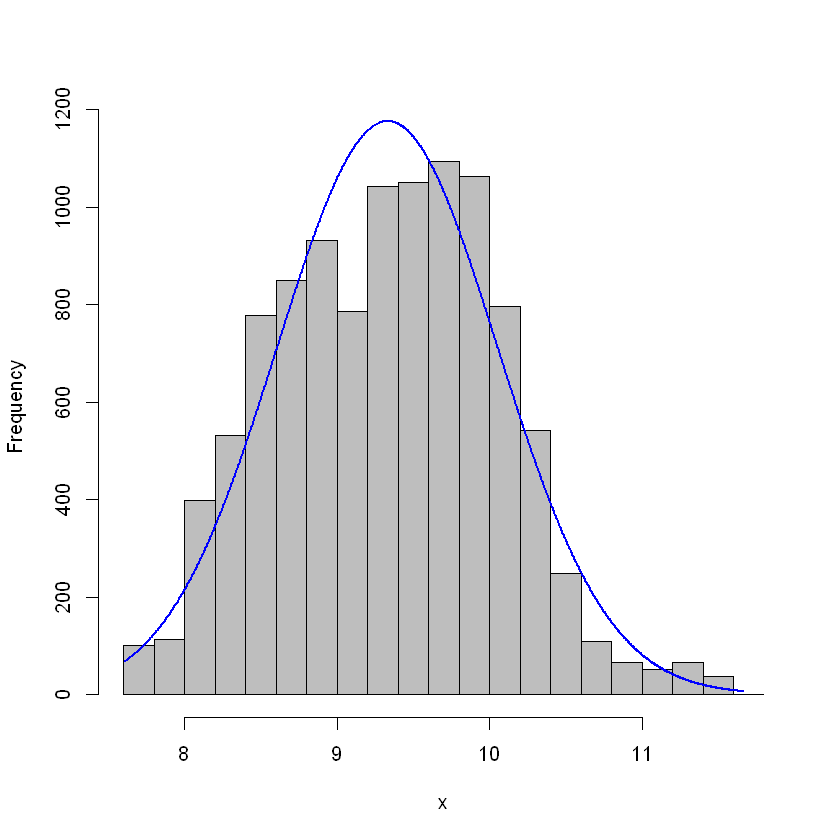

In [39]:
# выводим гистограмму распределения
# для преобразованной переменной CREDIT
plotNormalHistogram(var_log)

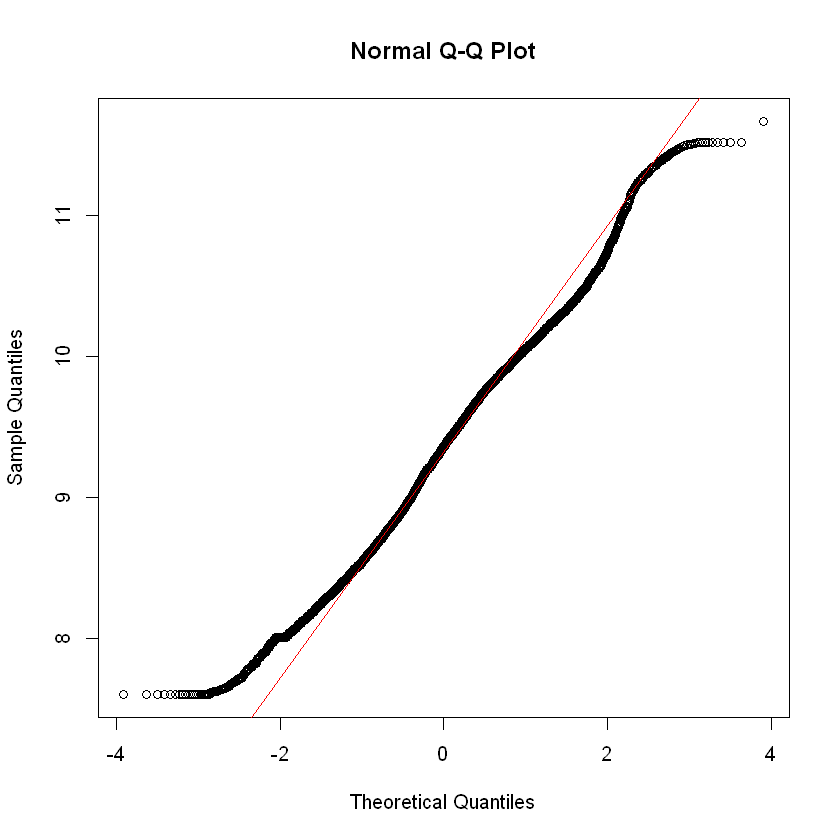

In [40]:
# выводим график квантиль-квантиль
# для преобразованной переменной CREDIT
qqnorm(var_log,
       ylab="Sample Quantiles")
qqline(var_log, 
       col="red")

In [41]:
# выполняем преобразование корней третьей степени,
# используем модуль, чтобы не вычислять корни
# отрицательных чисел, и затем учитываем знак числа
var_cube = sign(training$CREDIT) * abs(training$CREDIT)^(1/3)

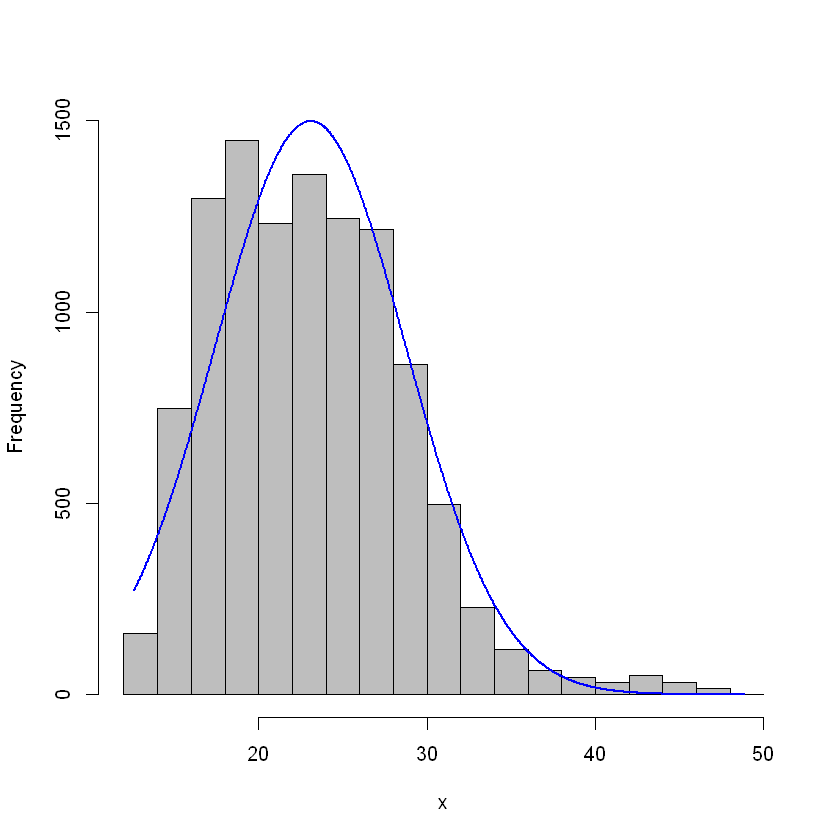

In [42]:
# выводим гистограмму распределения
# для преобразованной переменной CREDIT
plotNormalHistogram(var_cube)

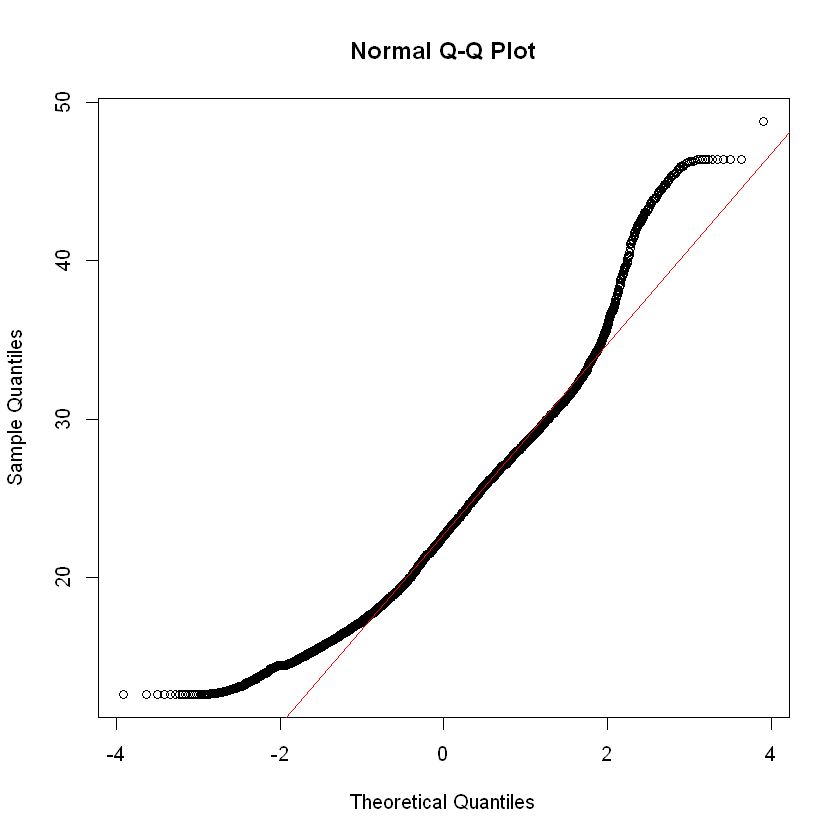

In [43]:
# выводим график квантиль-квантиль
# для преобразованной переменной CREDIT
qqnorm(var_cube,
       ylab="Sample Quantiles")
qqline(var_cube, 
       col="red")

In [44]:
# вычисляем лямбду преобразования Бокса-Кокса
# с помощью функции powerTransform пакета car
powerTransform(training$CREDIT)

Estimated transformation parameters 
training$CREDIT 
    -0.04163767 

In [45]:
# выполняем преобразование с помощью вычисленной лямбда,
# используя функцию bcPower пакета car
trans_var <-bcPower(training$CREDIT, -0.04163767)

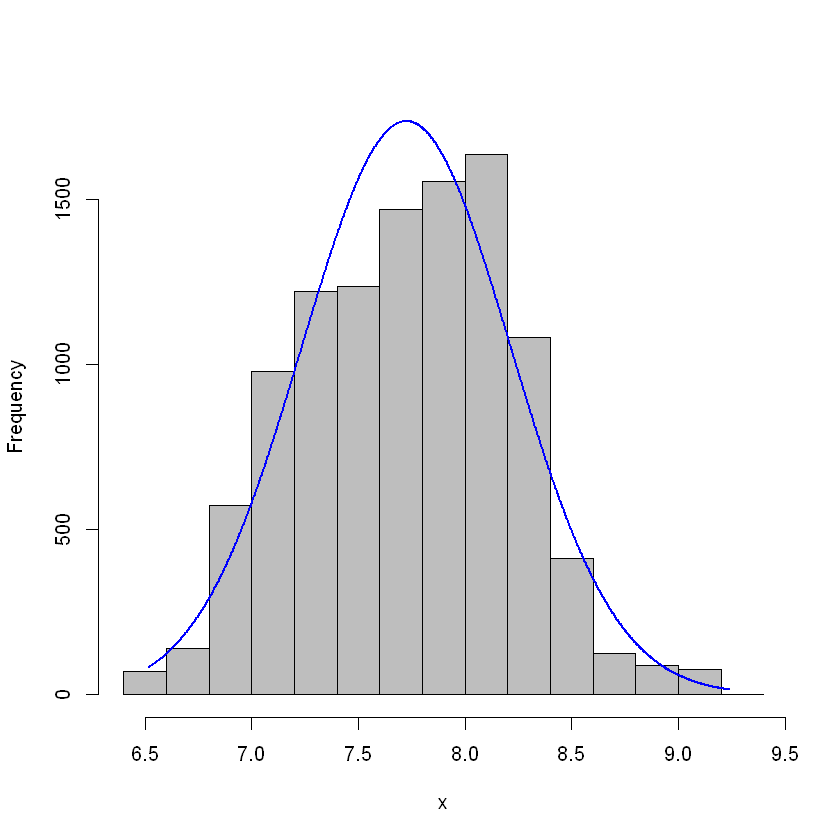

In [46]:
# выводим гистограмму распределения
# для преобразованной переменной CREDIT
plotNormalHistogram(trans_var)

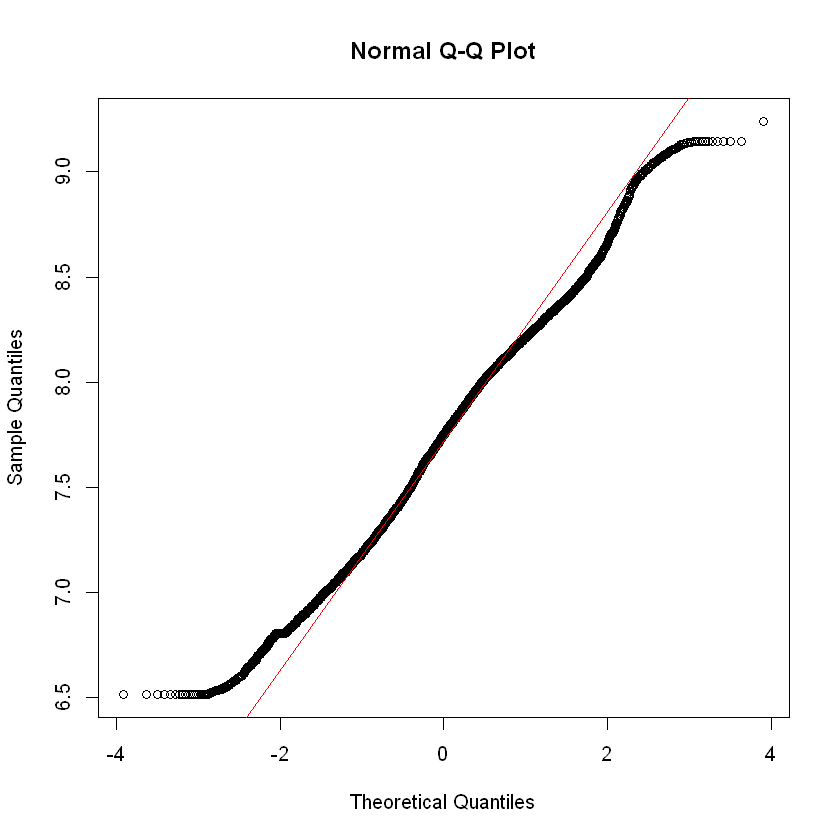

In [47]:
# выводим график квантиль-квантиль
# для преобразованной переменной CREDIT
qqnorm(trans_var,
       ylab="Sample Quantiles")
qqline(trans_var, 
       col="red")

## Написание и применение функций для конструирования новых признаков

In [48]:
# пишем функцию, создающую новые переменные
newFeaturesData <- 
  function(data) {
    data <- 
      data %>% mutate(
        PERSONAL_INCOME_INT = cut(PERSONAL_INCOME, 
                                  c(0,5000,10000,20000,50000,max(PERSONAL_INCOME))),
        FAMILY_INCOME_V2 = factor(FAMILY_INCOME, labels = levels(PERSONAL_INCOME_INT)),
        PERSONAL_FAMILY_INCOME = as.factor(
          ifelse(PERSONAL_INCOME_INT == FAMILY_INCOME_V2, 1, 0)
        ),
        PERSONAL_INCOME_INT = NULL, FAMILY_INCOME_V2 = NULL,
        PERSONAL_INCOME_LOG = log(PERSONAL_INCOME+0.01),
        CHILD_DEPENDANTS = CHILD_TOTAL/(CHILD_TOTAL+DEPENDANTS),
        CHILD_DEPENDANTS = ifelse(is.nan(CHILD_DEPENDANTS), 0, CHILD_DEPENDANTS),
        AUTO_FOR_FL = as.factor(ifelse(AUTO_RUS_FL == 0 & OWN_AUTO > 0, 1, 0)),
        CREDIT2=log(CREDIT),        
        WORK_TIME2=log(WORK_TIME+0.01),
        FACT_LIVING_TERM=log(FACT_LIVING_TERM+0.01),
        PAYMENT = CREDIT/TERM,
        PTI = PAYMENT/PERSONAL_INCOME,
        LOAN_AVG_DLQ_AMT=log(LOAN_AVG_DLQ_AMT+0.01),
        FST_SHARE = FST_PAYMENT/(FST_PAYMENT+CREDIT),
        LOAN_SHARE_CLOSED = LOAN_NUM_CLOSED/LOAN_NUM_TOTAL,
        AVR_NUM_PAYM = LOAN_NUM_PAYM/LOAN_NUM_TOTAL,
        TERM_ON_AVR_NUM = TERM/AVR_NUM_PAYM,
        LOAN_SHARE_DLQ = LOAN_DLQ_NUM/LOAN_NUM_PAYM,
        DLQ_TIME = LOAN_MAX_DLQ/LOAN_DLQ_NUM,
        PERSONAL_INCOME = NULL,
        DLQ_TIME = ifelse(is.nan(DLQ_TIME), 0, DLQ_TIME),
        LOAN_MAX_DLQ_RANGE = abs((LOAN_MAX_DLQ_AMT - LOAN_AVG_DLQ_AMT)/LOAN_AVG_DLQ_AMT),
        LOAN_MAX_DLQ_RANGE = ifelse(is.nan(LOAN_MAX_DLQ_RANGE), 0, LOAN_MAX_DLQ_RANGE)
      )
    return(data)
  }

In [49]:
# применяем функцию, создающую новые переменные,
# к обучающей выборке
training <- newFeaturesData(training)

In [50]:
# смотрим типы переменных
str(training)

'data.frame':	10657 obs. of  65 variables:
 $ TARGET                    : Factor w/ 2 levels "noResponse","Response": 1 1 1 1 1 1 1 1 1 1 ...
 $ AGE                       : int  49 32 52 39 30 29 41 53 43 54 ...
 $ SOCSTATUS_WORK_FL         : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ SOCSTATUS_PENS_FL         : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ GENDER                    : Factor w/ 2 levels "0","1": 2 2 2 2 1 1 2 1 2 2 ...
 $ CHILD_TOTAL               : int  2 3 4 1 0 0 0 2 0 2 ...
 $ DEPENDANTS                : int  1 3 0 1 0 0 0 0 0 0 ...
 $ EDUCATION                 : Factor w/ 5 levels "Высшее или несколько высших",..: 5 4 3 1 4 4 4 1 5 5 ...
 $ MARITAL_STATUS            : Factor w/ 5 levels "Вдовец/Вдова",..: 5 5 5 5 5 2 5 5 5 3 ...
 $ GEN_INDUSTRY              : Factor w/ 24 levels "Банк/Финансы",..: 20 20 5 11 2 20 17 4 11 11 ...
 $ GEN_TITLE                 : Factor w/ 11 levels "Высококвалифиц. специалист",..: 6 6 11 9 11 11 6 7 11 10 ...
 $ O

In [51]:
# применяем функцию, укрупняющую редкие
# категории, к обучающей выборке
testing <- replaceRareClass(testing)

In [52]:
# применяем функцию, обрабатывающую выбросы,
# к тестовой выборке
testing <- replaceOutlier(testing)

In [53]:
# смотрим количество пропусков по каждой переменной
# в тестовой выборке
print(sapply(testing, function(x) sum(is.na(x))))

                    TARGET                        AGE 
                         0                          0 
         SOCSTATUS_WORK_FL          SOCSTATUS_PENS_FL 
                         0                          0 
                    GENDER                CHILD_TOTAL 
                         0                          0 
                DEPENDANTS                  EDUCATION 
                         0                          0 
            MARITAL_STATUS               GEN_INDUSTRY 
                         0                          0 
                 GEN_TITLE               ORG_TP_STATE 
                         0                          0 
           ORG_TP_FCAPITAL                    JOB_DIR 
                         0                          0 
             FAMILY_INCOME            PERSONAL_INCOME 
                         0                          0 
      REG_ADDRESS_PROVINCE      FACT_ADDRESS_PROVINCE 
                         0                          0 
   POSTAL_

In [54]:
# импутируем пропуски в количественных 
# переменных медианами
testing[sapply(testing, is.numeric)] <- lapply(testing[sapply(testing,  
                                                              is.numeric)], function(x) 
                                                                ifelse(is.na(x), 
                                                                       median(x, na.rm = TRUE), x))

In [55]:
# смотрим количество пропусков по каждой переменной
# в тестовой выборке
print(sapply(testing, function(x) sum(is.na(x))))

                    TARGET                        AGE 
                         0                          0 
         SOCSTATUS_WORK_FL          SOCSTATUS_PENS_FL 
                         0                          0 
                    GENDER                CHILD_TOTAL 
                         0                          0 
                DEPENDANTS                  EDUCATION 
                         0                          0 
            MARITAL_STATUS               GEN_INDUSTRY 
                         0                          0 
                 GEN_TITLE               ORG_TP_STATE 
                         0                          0 
           ORG_TP_FCAPITAL                    JOB_DIR 
                         0                          0 
             FAMILY_INCOME            PERSONAL_INCOME 
                         0                          0 
      REG_ADDRESS_PROVINCE      FACT_ADDRESS_PROVINCE 
                         0                          0 
   POSTAL_

In [56]:
# применяем функцию, создающую новые переменные,
# к тестовой выборке
testing <- newFeaturesData(testing)

In [57]:
# смотрим типы переменных
str(testing)

'data.frame':	4566 obs. of  65 variables:
 $ TARGET                    : Factor w/ 2 levels "noResponse","Response": 1 2 1 2 1 1 1 1 1 1 ...
 $ AGE                       : int  35 62 42 31 40 43 38 38 31 54 ...
 $ SOCSTATUS_WORK_FL         : Factor w/ 2 levels "0","1": 2 1 2 2 2 2 2 2 2 2 ...
 $ SOCSTATUS_PENS_FL         : Factor w/ 2 levels "0","1": 1 2 1 1 1 1 1 1 1 1 ...
 $ GENDER                    : Factor w/ 2 levels "0","1": 1 1 2 2 1 2 1 1 1 2 ...
 $ CHILD_TOTAL               : int  1 3 1 1 1 2 0 4 1 2 ...
 $ DEPENDANTS                : int  1 0 1 1 1 2 0 4 1 0 ...
 $ EDUCATION                 : Factor w/ 5 levels "Высшее или несколько высших",..: 1 4 5 5 5 5 1 5 5 1 ...
 $ MARITAL_STATUS            : Factor w/ 5 levels "Вдовец/Вдова",..: 4 2 5 5 5 5 3 5 5 5 ...
 $ GEN_INDUSTRY              : Factor w/ 24 levels "Банк/Финансы",..: 3 8 20 3 3 8 1 3 8 20 ...
 $ GEN_TITLE                 : Factor w/ 11 levels "Высококвалифиц. специалист",..: 11 6 11 11 6 6 11 7 6 11 ...
 $ ORG_TP_

# Построение моделей на обучающей выборке с последующей проверкой на тестовой выборке

In [58]:
# загружаем библиотеку h2o, 
# перед загрузкой библиотеки h2o убедитесь, что библиотека h2o установлена 
# (сначала установите Java SE Development Kit 8, обратите внимание, 
# 9-я версия H2O не поддерживается, а затем после установки Java 
# установите пакет h2o с помощью команды install.packages("h2o")
# и затем загрузите библиотеку)
library(h2o)
h2o.init(nthreads=-1, max_mem_size = "8G")

Warning message:
"package 'h2o' was built under R version 3.4.3"
----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: 'h2o'

The following objects are masked from 'package:stats':

    cor, sd, var

The following objects are masked from 'package:base':

    %*%, %in%, &&, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc




H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    C:\Users\Gewissta\AppData\Local\Temp\Rtmp88vQkx/h2o_Gewissta_started_from_r.out
    C:\Users\Gewissta\AppData\Local\Temp\Rtmp88vQkx/h2o_Gewissta_started_from_r.err


Starting H2O JVM and connecting: ..... Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         10 seconds 417 milliseconds 
    H2O cluster version:        3.16.0.2 
    H2O cluster version age:    2 months and 3 days  
    H2O cluster name:           H2O_started_from_R_Gewissta_djm718 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   7.11 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Algos, AutoML, Core V3, Core V

In [59]:
# смотрим датафреймы перед преобразованием
# во фреймы H2O, обратите внимание, h2o
# не умеет обрабатывать упорядоченные факторы
# (ordered factors)
str(training)
str(testing)

'data.frame':	10657 obs. of  65 variables:
 $ TARGET                    : Factor w/ 2 levels "noResponse","Response": 1 1 1 1 1 1 1 1 1 1 ...
 $ AGE                       : int  49 32 52 39 30 29 41 53 43 54 ...
 $ SOCSTATUS_WORK_FL         : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ SOCSTATUS_PENS_FL         : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ GENDER                    : Factor w/ 2 levels "0","1": 2 2 2 2 1 1 2 1 2 2 ...
 $ CHILD_TOTAL               : int  2 3 4 1 0 0 0 2 0 2 ...
 $ DEPENDANTS                : int  1 3 0 1 0 0 0 0 0 0 ...
 $ EDUCATION                 : Factor w/ 5 levels "Высшее или несколько высших",..: 5 4 3 1 4 4 4 1 5 5 ...
 $ MARITAL_STATUS            : Factor w/ 5 levels "Вдовец/Вдова",..: 5 5 5 5 5 2 5 5 5 3 ...
 $ GEN_INDUSTRY              : Factor w/ 24 levels "Банк/Финансы",..: 20 20 5 11 2 20 17 4 11 11 ...
 $ GEN_TITLE                 : Factor w/ 11 levels "Высококвалифиц. специалист",..: 6 6 11 9 11 11 6 7 11 10 ...
 $ O

In [60]:
# выполняем преобразование во фреймы h2o
train <- as.h2o(training)
valid <- as.h2o(testing)

  |======================================================================| 100%
  |======================================================================| 100%


In [61]:
# взглянем на обучающий фрейм h2o
str(train)

Class 'H2OFrame' <environment: 0x000000002f083478> 
 - attr(*, "op")= chr "Parse"
 - attr(*, "id")= chr "training"
 - attr(*, "eval")= logi FALSE
 - attr(*, "nrow")= int 10657
 - attr(*, "ncol")= int 65
 - attr(*, "types")=List of 65
  ..$ : chr "enum"
  ..$ : chr "int"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "int"
  ..$ : chr "int"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "int"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "int"
  ..$ : chr "enum"
  ..$ : chr "int"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "real"
  ..$ : chr "int"
  ..$ : chr "real"
  ..$ : chr "enum"
  ..$ : chr "real"
  ..$ : chr "int"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "e

## Построение модели логистической регрессии

In [62]:
# строим модель логистической регрессии
glm1 <- h2o.glm(family= "binomial", training_frame = train, validation_frame = valid, 
                x=c(2:65), y=1, seed = 1000000)

# смотрим модель
summary(glm1)

  |======================================================================| 100%
Model Details:

H2OBinomialModel: glm
Model Key:  GLM_model_R_1517596815341_1 
GLM Model: summary
    family  link                                regularization
1 binomial logit Elastic Net (alpha = 0.5, lambda = 6.985E-5 )
  number_of_predictors_total number_of_active_predictors number_of_iterations
1                        429                         273                    4
  training_frame
1       training

H2OBinomialMetrics: glm
** Reported on training data. **

MSE:  0.09513622
RMSE:  0.3084416
LogLoss:  0.3232351
Mean Per-Class Error:  0.4731121
AUC:  0.7406235
Gini:  0.481247
R^2:  0.09305463
Residual Deviance:  6889.433
AIC:  7437.433

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
           Response noResponse    Error         Rate
Response         75       1194 0.940898   =1194/1269
noResponse       50       9338 0.005326     =50/9388
Totals          125      1

In [63]:
# строим модель логистической регрессии 
# с перебором lambda - силы штрафа 
glm2 <- h2o.glm(family= "binomial", training_frame = train, validation_frame = valid, 
                x=c(2:65), y=1, seed = 1000000, lambda_search = TRUE)

# смотрим модель
summary(glm2)

  |======================================================================| 100%
Model Details:

H2OBinomialModel: glm
Model Key:  GLM_model_R_1517596815341_4 
GLM Model: summary
    family  link                                regularization
1 binomial logit Elastic Net (alpha = 0.5, lambda = 0.001855 )
                                                                  lambda_search
1 nlambda = 100, lambda.max = 0.06985, lambda.min = 0.001855, lambda.1se = -1.0
  number_of_predictors_total number_of_active_predictors number_of_iterations
1                        429                          72                   58
  training_frame
1       training

H2OBinomialMetrics: glm
** Reported on training data. **

MSE:  0.09788423
RMSE:  0.3128646
LogLoss:  0.33301
Mean Per-Class Error:  0.5
AUC:  0.7177337
Gini:  0.4354674
R^2:  0.06685754
Residual Deviance:  7097.775
AIC:  7243.775

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
           Response noResponse  

In [64]:
# выполняем решетчатый поиск с перебором alpha и lambda,
# alpha задает тип регуляризации: значение 1 соответствует 
# l1-регуляризации (лассо), значение 0 соответствует 
# l2-регуляризации (гребневой регрессии), 
# промежуточное значение соответствует 
# комбинации штрафов l1 и l2 (эластичной сети),
# lambda задает силу штрафа
hyper_parameters <- list(alpha = c(0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1))
glm_grid <- h2o.grid(algorithm = "glm", grid_id = "glm_grid", 
                     hyper_params = hyper_parameters, 
                     training_frame = train, validation_frame = valid, x = c(2:65), y = "TARGET",
                     lambda_search=TRUE, family = "binomial",
                     seed = 1000000)

# выводим результаты решетчатого поиска
summary(glm_grid)

  |======================================================================| 100%
H2O Grid Details

Grid ID: glm_grid 
Used hyper parameters: 
  -  alpha 
Number of models: 11 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by increasing logloss
   alpha         model_ids             logloss
1  [0.0]  glm_grid_model_0  0.3387319931520807
2  [0.1]  glm_grid_model_1  0.3387759451439942
3  [0.2]  glm_grid_model_2 0.33880040800959427
4  [0.3]  glm_grid_model_3 0.33880954912173344
5  [0.4]  glm_grid_model_4  0.3388363453780678
6  [0.5]  glm_grid_model_5  0.3388705912957201
7  [0.6]  glm_grid_model_6 0.33889227632756636
8  [0.7]  glm_grid_model_7  0.3389151897063347
9  [0.8]  glm_grid_model_8 0.33892828891735644
10 [0.9]  glm_grid_model_9 0.33893573784532605
11 [1.0] glm_grid_model_10  0.3389471213617476
H2O Grid Summary

Grid ID: glm_grid 
Used hyper parameters: 
  -  alpha 
Number of models: 11 
  -  glm_grid_model_0 
  -  glm_grid_model_1 
  -  glm_grid_model_2 
  -  g

In [65]:
# сортируем по AUC
sorted_glm_grid <- h2o.getGrid("glm_grid", sort_by = "auc", decreasing = TRUE)

# выводим результаты решетчатого поиска,
# отсортировав по убыванию AUC
sorted_glm_grid

H2O Grid Details

Grid ID: glm_grid 
Used hyper parameters: 
  -  alpha 
Number of models: 11 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by decreasing auc
   alpha         model_ids                auc
1  [0.0]  glm_grid_model_0  0.702108822704074
2  [0.1]  glm_grid_model_1 0.7017348221941149
3  [0.3]  glm_grid_model_3 0.7016858404871803
4  [0.2]  glm_grid_model_2 0.7016343410289546
5  [0.4]  glm_grid_model_4 0.7015620129009577
6  [0.5]  glm_grid_model_5 0.7014780115624295
7  [0.6]  glm_grid_model_6 0.7014555806872912
8  [0.7]  glm_grid_model_7 0.7014542073684051
9  [0.8]  glm_grid_model_8 0.7013926369050153
10 [0.9]  glm_grid_model_9 0.7013793614891171
11 [1.0] glm_grid_model_10 0.7010554871184977

In [66]:
# объединяем фреймы в один
TrainValid <- h2o.rbind(train, valid)
str(TrainValid)

Class 'H2OFrame' <environment: 0x000000002cd16f50> 
 - attr(*, "op")= chr "rbind"
 - attr(*, "eval")= logi TRUE
 - attr(*, "id")= chr "RTMP_sid_a402_3"
 - attr(*, "nrow")= int 15223
 - attr(*, "ncol")= int 65
 - attr(*, "types")=List of 65
  ..$ : chr "enum"
  ..$ : chr "int"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "int"
  ..$ : chr "int"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "int"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "int"
  ..$ : chr "enum"
  ..$ : chr "int"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : chr "real"
  ..$ : chr "int"
  ..$ : chr "real"
  ..$ : chr "enum"
  ..$ : chr "real"
  ..$ : chr "int"
  ..$ : chr "enum"
  ..$ : chr "enum"
  ..$ : 

In [67]:
# выполняем решетчатый поиск с 5-блочной перекрестной проверкой
glm_grid_cv <- h2o.grid(algorithm = "glm", grid_id = "glm_grid_cv", 
                        hyper_params = hyper_parameters, 
                        training_frame = TrainValid, x = c(2:65), y = "TARGET",
                        lambda_search=TRUE, family = "binomial",
                        nfolds=5, keep_cross_validation_predictions=TRUE,
                        seed = 1000000)

# выводим результаты решетчатого поиска
# с перекрестной проверкой
summary(glm_grid_cv)

  |======================================================================| 100%


H2O Grid Details

Grid ID: glm_grid_cv 
Used hyper parameters: 
  -  alpha 
Number of models: 11 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by increasing logloss
   alpha            model_ids             logloss
1  [0.1]  glm_grid_cv_model_1  0.3375380852171801
2  [0.2]  glm_grid_cv_model_2 0.33764207057439743
3  [0.0]  glm_grid_cv_model_0  0.3376793623591618
4  [0.3]  glm_grid_cv_model_3  0.3377119154071847
5  [0.4]  glm_grid_cv_model_4 0.33774159903369866
6  [0.5]  glm_grid_cv_model_5  0.3377909670437917
7  [0.6]  glm_grid_cv_model_6 0.33783551191328526
8  [0.7]  glm_grid_cv_model_7 0.33789526400692155
9  [0.8]  glm_grid_cv_model_8  0.3378970658034342
10 [0.9]  glm_grid_cv_model_9 0.33790060283421547
11 [1.0] glm_grid_cv_model_10 0.33795305328686326
H2O Grid Summary

Grid ID: glm_grid_cv 
Used hyper parameters: 
  -  alpha 
Number of models: 11 
  -  glm_grid_cv_model_1 
  -  glm_grid_cv_model_2 
  -  glm_grid_cv_model_0 
  -  glm_grid_cv_model_3 
  -  glm_

In [68]:
# сортируем по AUC
sorted_glm_grid_cv <- h2o.getGrid("glm_grid_cv", sort_by = "auc", decreasing = TRUE)

# выводим результаты решетчатого поиска с
# перекрестной проверкой, отсортировав 
# по убыванию AUC
sorted_glm_grid_cv

H2O Grid Details

Grid ID: glm_grid_cv 
Used hyper parameters: 
  -  alpha 
Number of models: 11 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by decreasing auc
   alpha            model_ids                auc
1  [0.1]  glm_grid_cv_model_1 0.7022535576294574
2  [0.2]  glm_grid_cv_model_2 0.7020503744496256
3  [0.3]  glm_grid_cv_model_3 0.7018164514550427
4  [0.4]  glm_grid_cv_model_4  0.701709232462627
5  [0.5]  glm_grid_cv_model_5 0.7016728755331322
6  [0.6]  glm_grid_cv_model_6 0.7015153494141658
7  [0.0]  glm_grid_cv_model_0 0.7013618972465521
8  [0.8]  glm_grid_cv_model_8 0.7013064050910072
9  [0.7]  glm_grid_cv_model_7 0.7012874138935403
10 [0.9]  glm_grid_cv_model_9 0.7012452546696948
11 [1.0] glm_grid_cv_model_10 0.7011597428423144

In [69]:
# записываем идентификатор наилучшей модели
opt_model_id <- sorted_glm_grid_cv@model_ids[[1]]

# извлекаем наилучшую модель
opt_model <- h2o.getModel(opt_model_id)

# смотрим наилучшую модель
opt_model

Model Details:

H2OBinomialModel: glm
Model ID:  glm_grid_cv_model_1 
GLM Model: summary
    family  link                               regularization
1 binomial logit Elastic Net (alpha = 0.1, lambda = 0.00168 )
                                                                  lambda_search
1 nlambda = 100, lambda.max = 0.3376, lambda.min = 0.00168, lambda.1se = 0.0362
  number_of_predictors_total number_of_active_predictors number_of_iterations
1                        429                         222                   74
   training_frame
1 RTMP_sid_a402_3

Coefficients: glm coefficients
                                                                   names
1                                                              Intercept
2                                  REG_ADDRESS_PROVINCE.<0xC0E4FBE3E5FF>
3               REG_ADDRESS_PROVINCE.<0xC0EBF2E0E9F1EAE8E9> <0xEAF0E0E9>
4           REG_ADDRESS_PROVINCE.<0xC0ECF3F0F1EAE0FF> <0xEEE1EBE0F1F2FC>
5 REG_ADDRESS_PROVINCE.<0xC0F0F5E0EDE3

In [70]:
# берем значения alpha и lambda из наилучшей модели
# и добавляем список интеракций, обучаем модель
# с 5-блочной перекрестной проверкой
glm3 <- h2o.glm(family= "binomial", training_frame = TrainValid, 
                x=c(2:65), y=1, alpha = 0.1, lambda = 0.001844,
                interactions=c("GENDER", "EDUCATION", "REGION_NM",
                               "REG_ADDRESS_PROVINCE", "TP_PROVINCE", 
                               "FACT_TP_FL", "GEN_PHONE_FL"),
                nfolds=5, keep_cross_validation_predictions=TRUE,
                seed = 1000000)
glm3

  |======================================================================| 100%


Model Details:

H2OBinomialModel: glm
Model ID:  GLM_model_R_1517596815341_216 
GLM Model: summary
    family  link                                regularization
1 binomial logit Elastic Net (alpha = 0.1, lambda = 0.001844 )
  number_of_predictors_total number_of_active_predictors number_of_iterations
1                       2595                         358                    6
   training_frame
1 RTMP_sid_a402_3

Coefficients: glm coefficients
                                                                                                                                                 names
1                                                                                                                                            Intercept
2                                  EDUCATION_REG_ADDRESS_PROVINCE.<0xC2FBF1F8E5E5> <0xE8EBE8> <0xEDE5F1EAEEEBFCEAEE> <0xE2FBF1F8E8F5>_<0xC0E4FBE3E5FF>
3               EDUCATION_REG_ADDRESS_PROVINCE.<0xC2FBF1F8E5E5> <0xE8EBE8> <0xEDE5F1EAEEEBFCEAEE> 

## Построение модели случайного леса

In [71]:
# строим модель случайного леса, все значения
# параметров взяты по умолчанию, ntrees - количество 
# деревьев, max_depth - глубина, min_rows - 
# количество наблюдений в терминальном узле, 
# mtries - количество случайно отбираемых предикторов
# sample_rate - процент отобранных строк для построения дерева,
# col_sample_rate - процент случайно отбираемых столбцов 
# для каждого разбиения узла, col_sample_rate_per_tree -
# процент случайно отбираемых столбцов для каждого дерева,
# col_sample_rate_per_tree - относительное изменение 
# отбора столбцов для каждого уровня дерева
drf1 <- h2o.randomForest(training_frame = train, validation_frame = valid, 
                         x=c(2:65), y=1, seed = 1000000)

# выводим информацию о модели
summary(drf1)

  |======================================================================| 100%
Model Details:

H2OBinomialModel: drf
Model Key:  DRF_model_R_1517596815341_234 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1              50                       50              654287        20
  max_depth mean_depth min_leaves max_leaves mean_leaves
1        20   20.00000        771        953   893.62000

H2OBinomialMetrics: drf
** Reported on training data. **
** Metrics reported on Out-Of-Bag training samples **

MSE:  0.1058633
RMSE:  0.3253663
LogLoss:  0.6693798
Mean Per-Class Error:  0.5
AUC:  0.6300866
Gini:  0.2601733

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
           Response noResponse    Error         Rate
Response          0       1269 1.000000   =1269/1269
noResponse        0       9388 0.000000      =0/9388
Totals            0      10657 0.119077  =1269/10657

Maximum Metrics: Maximum metrics at their 

In [72]:
# выполняем решетчатый поиск, меняя глубину
hyper_parameters <- list(max_depth=c(6, 8, 10, 12, 14, 16))
drf_grid <- h2o.grid(algorithm = "drf", grid_id = "drf_grid", 
                     hyper_params = hyper_parameters,
                     ntrees = 800, min_rows=1,
                     sample_rate = 1,
                     col_sample_rate_change_per_level = 1, 
                     col_sample_rate_per_tree = 1,
                     training_frame = train, validation_frame = valid, x = c(2:65), y = "TARGET",
                     seed = 1000000)


  |======================================================================| 100%


In [73]:
# сортируем результаты по AUC
sorted_drf_grid <- h2o.getGrid("drf_grid", sort_by = "auc", decreasing = TRUE)
sorted_drf_grid

H2O Grid Details

Grid ID: drf_grid 
Used hyper parameters: 
  -  max_depth 
Number of models: 6 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by decreasing auc
  max_depth        model_ids                auc
1        10 drf_grid_model_2 0.6580701482131519
2         8 drf_grid_model_1 0.6579591382698654
3        12 drf_grid_model_3 0.6574370482066973
4        14 drf_grid_model_4  0.656530886628406
5         6 drf_grid_model_0 0.6556119074071786
6        16 drf_grid_model_5 0.6546764483593188

In [74]:
# выполняем решетчатый поиск, меняя количество
# случайно отбираемых предикторов
hyper_parameters2 <- list(mtries=c(4, 6, 8, 10, 12))
drf_grid2 <- h2o.grid(algorithm = "drf", grid_id = "drf_grid2", 
                      hyper_params = hyper_parameters2,
                      ntrees = 800, max_depth=10, min_rows=1, sample_rate=1,
                      col_sample_rate_change_per_level = 1, 
                      col_sample_rate_per_tree = 1,
                      training_frame = train, validation_frame = valid, x = c(2:65), y = "TARGET",
                      seed = 1000000)

  |======================================================================| 100%


In [75]:
# сортируем результаты по AUC
sorted_drf_grid2 <- h2o.getGrid("drf_grid2", sort_by = "auc", decreasing = TRUE)
sorted_drf_grid2

H2O Grid Details

Grid ID: drf_grid2 
Used hyper parameters: 
  -  mtries 
Number of models: 5 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by decreasing auc
  mtries         model_ids                auc
1      4 drf_grid2_model_0  0.663380085685943
2      6 drf_grid2_model_1 0.6597433083892846
3      8 drf_grid2_model_2 0.6580701482131519
4     12 drf_grid2_model_4 0.6573949330941927
5     10 drf_grid2_model_3 0.6560097121111619

In [76]:
# выполняем решетчатый поиск, меняя количество
# случайно отбираемых строк (наблюдений)
hyper_parameters3 <- list(sample_rate=c(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1))
drf_grid3 <- h2o.grid(algorithm = "drf", grid_id = "drf_grid3", 
                      hyper_params = hyper_parameters3,
                      ntrees = 800, max_depth=10, min_rows=1, mtries=4,
                      col_sample_rate_change_per_level = 1, 
                      col_sample_rate_per_tree = 1,
                      training_frame = train, validation_frame = valid, x = c(2:65), y = "TARGET",
                      seed = 1000000)

  |======================================================================| 100%


In [77]:
# сортируем результаты по AUC
sorted_drf_grid3 <- h2o.getGrid("drf_grid3", sort_by = "auc", decreasing = TRUE)
sorted_drf_grid3

H2O Grid Details

Grid ID: drf_grid3 
Used hyper parameters: 
  -  sample_rate 
Number of models: 10 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by decreasing auc
   sample_rate         model_ids                auc
1          0.2 drf_grid3_model_1 0.6710033788222326
2          0.3 drf_grid3_model_2 0.6691500849855504
3          0.4 drf_grid3_model_3 0.6668694600888354
4          0.1 drf_grid3_model_0 0.6663112059616688
5          0.6 drf_grid3_model_5 0.6661944738563572
6          0.5 drf_grid3_model_4 0.6660974259884119
7          0.7 drf_grid3_model_6  0.665954829710747
8          0.8 drf_grid3_model_7 0.6647495135017847
9          0.9 drf_grid3_model_8 0.6638907314250609
10         1.0 drf_grid3_model_9  0.663380085685943

In [78]:
# выполняем решетчатый поиск, меняя тип
# гистограммы расщепляющих значений
hyper_parameters4 <- list(histogram_type=c("UniformAdaptive", "Random", "QuantilesGlobal", "RoundRobin"))
drf_grid4 <- h2o.grid(algorithm = "drf", grid_id = "drf_grid4", 
                      hyper_params = hyper_parameters4,
                      ntrees = 800, max_depth=10, min_rows=1, mtries=4, sample_rate=0.2,
                      col_sample_rate_per_tree = 1,
                      col_sample_rate_change_per_level = 1, 
                      training_frame = train, validation_frame = valid, x = c(2:65), y = "TARGET",
                      seed = 1000000)

  |======================================================================| 100%


In [79]:
# сортируем результаты по AUC
sorted_drf_grid4 <- h2o.getGrid("drf_grid4", sort_by = "auc", decreasing = TRUE)
sorted_drf_grid4

H2O Grid Details

Grid ID: drf_grid4 
Used hyper parameters: 
  -  histogram_type 
Number of models: 4 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by decreasing auc
   histogram_type         model_ids                auc
1 QuantilesGlobal drf_grid4_model_2  0.673909550471529
2      RoundRobin drf_grid4_model_3 0.6738646887212525
3          Random drf_grid4_model_1 0.6733329854258823
4 UniformAdaptive drf_grid4_model_0 0.6710033788222326

In [80]:
# выполняем решетчатый поиск, меняя тип
# кодировки категориальных предикторов
hyper_parameters5 <- list(categorical_encoding = c("Enum", "Binary", "Eigen", "LabelEncoder", 
                                                   "SortByResponse", "EnumLimited"))
drf_grid5 <- h2o.grid(algorithm = "drf", grid_id = "drf_grid5", 
                      hyper_params = hyper_parameters5,
                      ntrees = 800, max_depth=10, min_rows=1, mtries=4, sample_rate=0.2,
                      histogram_type="QuantilesGlobal",
                      col_sample_rate_per_tree = 1,
                      col_sample_rate_change_per_level = 1,
                      training_frame = train, validation_frame = valid, x = c(2:65), y = "TARGET",
                      seed = 1000000)

  |======================================================================| 100%


In [81]:
# сортируем результаты по AUC
sorted_drf_grid5 <- h2o.getGrid("drf_grid5", sort_by = "auc", decreasing = TRUE)
sorted_drf_grid5

H2O Grid Details

Grid ID: drf_grid5 
Used hyper parameters: 
  -  categorical_encoding 
Number of models: 6 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by decreasing auc
  categorical_encoding         model_ids                auc
1          EnumLimited drf_grid5_model_5 0.6757053938014794
2                Eigen drf_grid5_model_2 0.6742892731435133
3       SortByResponse drf_grid5_model_4  0.673909550471529
4                 Enum drf_grid5_model_0  0.673909550471529
5         LabelEncoder drf_grid5_model_3 0.6705009729964307
6               Binary drf_grid5_model_1 0.6702443912512263

In [82]:
# выполняем решетчатый поиск, меняя количество
# интервалов в гистограмме расщепляющих значений
# для количественных признаков
hyper_parameters6 <- list(nbins = c(2, 4, 6, 8, 10))
drf_grid6 <- h2o.grid(algorithm = "drf", grid_id = "drf_grid6", 
                      hyper_params = hyper_parameters6,
                      ntrees = 800, max_depth=10, min_rows=1, mtries=4, sample_rate=0.2,
                      histogram_type="QuantilesGlobal", categorical_encoding="EnumLimited",
                      col_sample_rate_per_tree = 1,
                      col_sample_rate_change_per_level = 1,
                      training_frame = train, validation_frame = valid, x = c(2:65), y = "TARGET",
                      seed = 1000000)

  |======================================================================| 100%


In [83]:
# сортируем результаты по AUC
sorted_drf_grid6 <- h2o.getGrid("drf_grid6", sort_by = "auc", decreasing = TRUE)
sorted_drf_grid6

H2O Grid Details

Grid ID: drf_grid6 
Used hyper parameters: 
  -  nbins 
Number of models: 5 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by decreasing auc
  nbins         model_ids                auc
1     4 drf_grid6_model_1 0.6822730624873827
2     6 drf_grid6_model_2 0.6782847155559035
3     8 drf_grid6_model_3 0.6766232285903019
4    10 drf_grid6_model_4 0.6752146611862088
5     2 drf_grid6_model_0 0.6704773976888874

In [84]:
# строим модель с параметрами, найденными в ходе предыдущих
# итераций решетчатого поиска, увеличив число деревьев и
# уменьшив глубину
drf2 <- h2o.randomForest(ntrees = 1000, max_depth = 8, min_rows = 1,
                         mtries=4, sample_rate = 0.2,
                         histogram_type="QuantilesGlobal", 
                         categorical_encoding="EnumLimited",
                         nbins=4, col_sample_rate_change_per_level = 1, 
                         col_sample_rate_per_tree = 1,
                         training_frame = train, validation_frame = valid, 
                         x=c(2:65), y=1, seed = 1000000)
summary(drf2)

  |======================================================================| 100%
Model Details:

H2OBinomialModel: drf
Model Key:  DRF_model_R_1517596815341_2641 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1            1000                     1000             1235217         8
  max_depth mean_depth min_leaves max_leaves mean_leaves
1         8    8.00000         46        142    93.54500

H2OBinomialMetrics: drf
** Reported on training data. **
** Metrics reported on Out-Of-Bag training samples **

MSE:  0.1005362
RMSE:  0.3170744
LogLoss:  0.3445284
Mean Per-Class Error:  0.5
AUC:  0.6903462
Gini:  0.3806924

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
           Response noResponse    Error         Rate
Response          0       1269 1.000000   =1269/1269
noResponse        0       9388 0.000000      =0/9388
Totals            0      10657 0.119077  =1269/10657

Maximum Metrics: Maximum metrics at their

## Построение модели градиентного бустинга

In [85]:
# строим модель градиентного бустинга, перечислены 
# значения параметров по умолчанию: learn_rate -
# темп обучения, ntrees - количество деревьев (итераций),
# max_depth - глубина, min_rows - количество
# наблюдений в терминальном узле, sample_rate -
# процент отобранных строк для построения дерева,
# col_sample_rate - процент случайно отбираемых столбцов 
# для каждого разбиения узла, col_sample_rate_per_tree -
# процент случайно отбираемых столбцов для каждого дерева,
# col_sample_rate_per_tree - относительное изменение 
# отбора столбцов для каждого уровня дерева
gbm1 <- h2o.gbm(learn_rate=0.1, ntrees = 50, max_depth = 5, min_rows = 10,
                sample_rate = 1, col_sample_rate = 1,
                col_sample_rate_change_per_level = 1, 
                col_sample_rate_per_tree = 1,
                training_frame = train, validation_frame = valid, 
                x=c(2:65), y=1, seed = 1000000)

summary(gbm1)

  |======================================================================| 100%
Model Details:

H2OBinomialModel: gbm
Model Key:  GBM_model_R_1517596815341_2728 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1              50                       50               27726         5
  max_depth mean_depth min_leaves max_leaves mean_leaves
1         5    5.00000         22         32    28.32000

H2OBinomialMetrics: gbm
** Reported on training data. **

MSE:  0.06398124
RMSE:  0.2529451
LogLoss:  0.2249162
Mean Per-Class Error:  0.224301
AUC:  0.9468338
Gini:  0.8936676

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
           Response noResponse    Error        Rate
Response        720        549 0.432624   =549/1269
noResponse      150       9238 0.015978   =150/9388
Totals          870       9787 0.065591  =699/10657

Maximum Metrics: Maximum metrics at their respective thresholds
                        metri

In [86]:
# выполняем решетчатый поиск, при этом уменьшаем
# глубину и увеличиваем количество наблюдений в
# листьях, пробуем найти оптимальную сложность
# путем комбинирования learn_rate и ntrees, а
# также пробуем внести рандомизацию, перебирая
# небольшие значения col_sample_rate и
# col_sample_rate_per_tree
hyper_parameters <- list(learn_rate = c(0.1, 0.15, 0.2), 
                         ntrees=c(50, 55, 60, 65, 70),
                         col_sample_rate=c(0.14, 0.16, 0.18, 0.20),
                         col_sample_rate_per_tree=c(0.15, 0.25, 0.35))
gbm_grid <- h2o.grid(algorithm = "gbm", grid_id = "gbm_grid", 
                     hyper_params = hyper_parameters, max_depth=2, min_rows=125,
                     training_frame = train, validation_frame = valid, x = c(2:65), y = "TARGET",
                     seed = 1000000)

# сортируем результаты по AUC
sorted_gbm_grid <- h2o.getGrid("gbm_grid", sort_by = "auc", decreasing = TRUE)
sorted_gbm_grid

  |======================================================================| 100%


H2O Grid Details

Grid ID: gbm_grid 
Used hyper parameters: 
  -  col_sample_rate 
  -  col_sample_rate_per_tree 
  -  learn_rate 
  -  ntrees 
Number of models: 180 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by decreasing auc
  col_sample_rate col_sample_rate_per_tree learn_rate ntrees          model_ids
1            0.18                     0.35       0.15     65 gbm_grid_model_130
2             0.2                     0.35       0.15     65 gbm_grid_model_131
3             0.2                     0.35       0.15     70 gbm_grid_model_167
4            0.18                     0.35       0.15     70 gbm_grid_model_166
5            0.18                     0.35       0.15     55  gbm_grid_model_58
                 auc
1 0.6858967932546238
2 0.6858967932546238
3 0.6857178040264794
4 0.6857178040264794
5  0.685536754820006

---
    col_sample_rate col_sample_rate_per_tree learn_rate ntrees
175            0.18                     0.25        0.1     50
176      

# Предварительная подготовка данных для построения модели на всей исторической выборке

In [87]:
# преобразовываем весь обучающий набор и итоговый тестовый набор
# перевыгружаем данные
OTPset <- read.csv2("Credit_OTP.csv", stringsAsFactors = F)
OTPset_test <- read.csv2("Credit_OTP_new.csv", stringsAsFactors = F)

In [88]:
# удаляем переменную AGREEMENT_RK
OTPset$AGREEMENT_RK = NULL

# применяем функции предобработки
OTPset <- preProcessData(OTPset)

# применяем функцию, укрупняющую редкие
# категории
OTPset <- replaceRareClass(OTPset)

# применяем функцию, обрабатывающую выбросы
OTPset <- replaceOutlier(OTPset)

# смотрим количество пропусков по каждой переменной
print(sapply(OTPset, function(x) sum(is.na(x))))

                    TARGET                        AGE 
                         0                          0 
         SOCSTATUS_WORK_FL          SOCSTATUS_PENS_FL 
                         0                          0 
                    GENDER                CHILD_TOTAL 
                         0                          0 
                DEPENDANTS                  EDUCATION 
                         0                          0 
            MARITAL_STATUS               GEN_INDUSTRY 
                         0                          0 
                 GEN_TITLE               ORG_TP_STATE 
                         0                          0 
           ORG_TP_FCAPITAL                    JOB_DIR 
                         0                          0 
             FAMILY_INCOME            PERSONAL_INCOME 
                         0                          0 
      REG_ADDRESS_PROVINCE      FACT_ADDRESS_PROVINCE 
                         0                          0 
   POSTAL_

In [89]:
# импутируем пропуски в количественных 
# переменных медианами
OTPset[sapply(OTPset, is.numeric)] <- lapply(OTPset[sapply(OTPset,  
                                                           is.numeric)], function(x) 
                                                             ifelse(is.na(x), 
                                                                    median(x, na.rm = TRUE), x))

In [90]:
# смотрим количество пропусков по каждой переменной
print(sapply(OTPset, function(x) sum(is.na(x))))

                    TARGET                        AGE 
                         0                          0 
         SOCSTATUS_WORK_FL          SOCSTATUS_PENS_FL 
                         0                          0 
                    GENDER                CHILD_TOTAL 
                         0                          0 
                DEPENDANTS                  EDUCATION 
                         0                          0 
            MARITAL_STATUS               GEN_INDUSTRY 
                         0                          0 
                 GEN_TITLE               ORG_TP_STATE 
                         0                          0 
           ORG_TP_FCAPITAL                    JOB_DIR 
                         0                          0 
             FAMILY_INCOME            PERSONAL_INCOME 
                         0                          0 
      REG_ADDRESS_PROVINCE      FACT_ADDRESS_PROVINCE 
                         0                          0 
   POSTAL_

In [91]:
# применяем функцию, создающую новые переменные
OTPset <- newFeaturesData(OTPset)

In [92]:
# удаляем переменную AGREEMENT_RK
OTPset_test$AGREEMENT_RK = NULL

# применяем функции предобработки
OTPset_test <- preProcessDataTest(OTPset_test)

# применяем функцию, укрупняющую редкие
# категории
OTPset_test <- replaceRareClass(OTPset_test)

# применяем функцию, обрабатывающую выбросы
OTPset_test <- replaceOutlier(OTPset_test)

# смотрим количество пропусков по каждой переменной
print(sapply(OTPset_test, function(x) sum(is.na(x))))

                    TARGET                        AGE 
                         0                          0 
         SOCSTATUS_WORK_FL          SOCSTATUS_PENS_FL 
                         0                          0 
                    GENDER                CHILD_TOTAL 
                         0                          0 
                DEPENDANTS                  EDUCATION 
                         0                          0 
            MARITAL_STATUS               GEN_INDUSTRY 
                         0                          0 
                 GEN_TITLE               ORG_TP_STATE 
                         0                          0 
           ORG_TP_FCAPITAL                    JOB_DIR 
                         0                          0 
             FAMILY_INCOME            PERSONAL_INCOME 
                         0                          0 
      REG_ADDRESS_PROVINCE      FACT_ADDRESS_PROVINCE 
                         0                          0 
   POSTAL_

In [93]:
# импутируем пропуски в количественных 
# переменных медианами
OTPset_test[sapply(OTPset_test, is.numeric)] <- lapply(OTPset_test[sapply(OTPset_test,  
                                                                          is.numeric)], function(x) 
                                                                            ifelse(is.na(x), 
                                                                                   median(x, na.rm = TRUE), x))

In [94]:
# смотрим количество пропусков по каждой переменной
print(sapply(OTPset_test, function(x) sum(is.na(x))))

                    TARGET                        AGE 
                         0                          0 
         SOCSTATUS_WORK_FL          SOCSTATUS_PENS_FL 
                         0                          0 
                    GENDER                CHILD_TOTAL 
                         0                          0 
                DEPENDANTS                  EDUCATION 
                         0                          0 
            MARITAL_STATUS               GEN_INDUSTRY 
                         0                          0 
                 GEN_TITLE               ORG_TP_STATE 
                         0                          0 
           ORG_TP_FCAPITAL                    JOB_DIR 
                         0                          0 
             FAMILY_INCOME            PERSONAL_INCOME 
                         0                          0 
      REG_ADDRESS_PROVINCE      FACT_ADDRESS_PROVINCE 
                         0                          0 
   POSTAL_

In [95]:
# применяем функцию, создающую новые переменные
OTPset_test <- newFeaturesData(OTPset_test)

In [96]:
# смотрим типы переменных
str(OTPset)
str(OTPset_test)

'data.frame':	15223 obs. of  65 variables:
 $ TARGET                    : Factor w/ 2 levels "noResponse","Response": 1 1 1 1 1 1 1 1 1 1 ...
 $ AGE                       : int  49 32 52 39 30 29 35 41 53 43 ...
 $ SOCSTATUS_WORK_FL         : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ SOCSTATUS_PENS_FL         : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ GENDER                    : Factor w/ 2 levels "0","1": 2 2 2 2 1 1 1 2 1 2 ...
 $ CHILD_TOTAL               : int  2 3 4 1 0 0 1 0 2 0 ...
 $ DEPENDANTS                : int  1 3 0 1 0 0 1 0 0 0 ...
 $ EDUCATION                 : Factor w/ 5 levels "Высшее или несколько высших",..: 5 4 3 1 4 4 1 4 1 5 ...
 $ MARITAL_STATUS            : Factor w/ 5 levels "Вдовец/Вдова",..: 5 5 5 5 5 2 4 5 5 5 ...
 $ GEN_INDUSTRY              : Factor w/ 24 levels "Банк/Финансы",..: 20 20 5 11 2 20 3 17 4 11 ...
 $ GEN_TITLE                 : Factor w/ 11 levels "Высококвалифиц. специалист",..: 6 6 11 9 11 11 11 6 7 11 ...
 $ OR

In [97]:
# выполняем преобразование во фреймы h2o
tr <- as.h2o(OTPset)
val <- as.h2o(OTPset_test)

  |======================================================================| 100%
  |======================================================================| 100%


# Построение моделей на всей исторической выборке (без разбиения на обучение и тест) с последующей проверкой на настоящем тестовом наборе данных

## Построение модели логистической регрессии

In [98]:
# обучаем модель логистической регрессии на всем обучающем наборе
# проверяем на тестовом наборе
glm_full <- h2o.glm(family= "binomial", training_frame = tr, validation_frame = val, 
                    x=c(2:65), y=1, seed = 1000000, alpha = 0.1, lambda = 0.001844,
                    interactions=c("GENDER", "EDUCATION", "REGION_NM",
                                   "REG_ADDRESS_PROVINCE", "TP_PROVINCE", 
                                   "FACT_TP_FL", "GEN_PHONE_FL"))
# смотрим модель
glm_full

  |======================================================================| 100%


Model Details:

H2OBinomialModel: glm
Model ID:  GLM_model_R_1517596815341_24627 
GLM Model: summary
    family  link                                regularization
1 binomial logit Elastic Net (alpha = 0.1, lambda = 0.001844 )
  number_of_predictors_total number_of_active_predictors number_of_iterations
1                       2595                         358                    5
  training_frame
1         OTPset

Coefficients: glm coefficients
                                                                                                                                                 names
1                                                                                                                                            Intercept
2                                  EDUCATION_REG_ADDRESS_PROVINCE.<0xC2FBF1F8E5E5> <0xE8EBE8> <0xEDE5F1EAEEEBFCEAEE> <0xE2FBF1F8E8F5>_<0xC0E4FBE3E5FF>
3               EDUCATION_REG_ADDRESS_PROVINCE.<0xC2FBF1F8E5E5> <0xE8EBE8> <0xEDE5F1EAEEEBFCEAEE> 

## Построение модели случайного леса

In [100]:
# строим модель случайного леса на всем обучающем 
# наборе и проверяем на настоящем тестовом наборе
drf_full <- h2o.randomForest(ntrees = 1000, max_depth = 8, min_rows = 1,
                             mtries=4, sample_rate = 0.2,
                             histogram_type="QuantilesGlobal", 
                             categorical_encoding="EnumLimited",
                             nbins=4,
                             col_sample_rate_change_per_level = 1, 
                             col_sample_rate_per_tree = 1,
                             training_frame = tr, validation_frame = val, 
                             x=c(2:65), y=1, seed = 1000000)

# смотрим модель
drf_full

  |======================================================================| 100%


Model Details:

H2OBinomialModel: drf
Model ID:  DRF_model_R_1517596815341_24790 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1            1000                     1000             1375548         8
  max_depth mean_depth min_leaves max_leaves mean_leaves
1         8    8.00000         62        158   104.73300


H2OBinomialMetrics: drf
** Reported on training data. **
** Metrics reported on Out-Of-Bag training samples **

MSE:  0.1005865
RMSE:  0.3171538
LogLoss:  0.344725
Mean Per-Class Error:  0.5
AUC:  0.6887624
Gini:  0.3775248

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
           Response noResponse    Error         Rate
Response          0       1812 1.000000   =1812/1812
noResponse        0      13411 0.000000     =0/13411
Totals            0      15223 0.119030  =1812/15223

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold    value idx
1  

## Построение модели градиентного бустинга

In [101]:
# строим модель градиентного бустинга на всем обучающем 
# наборе и проверяем на настоящем тестовом наборе
gbm_full <- h2o.gbm(learn_rate=0.15, ntrees = 65, max_depth = 2, min_rows=125,
                    sample_rate = 1, col_sample_rate = 0.2,
                    col_sample_rate_change_per_level = 1, 
                    col_sample_rate_per_tree = 0.35,
                    training_frame = tr, validation_frame = val,
                    x=c(2:65), y=1, seed = 1000000)

# смотрим модель
summary(gbm_full)

  |======================================================================| 100%
Model Details:

H2OBinomialModel: gbm
Model Key:  GBM_model_R_1517596815341_24847 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1              65                       65                7637         2
  max_depth mean_depth min_leaves max_leaves mean_leaves
1         2    2.00000          3          4     3.95385

H2OBinomialMetrics: gbm
** Reported on training data. **

MSE:  0.0962423
RMSE:  0.3102294
LogLoss:  0.3277864
Mean Per-Class Error:  0.4878212
AUC:  0.7404621
Gini:  0.4809241

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
           Response noResponse    Error         Rate
Response         49       1763 0.972958   =1763/1812
noResponse       36      13375 0.002684    =36/13411
Totals           85      15138 0.118176  =1799/15223

Maximum Metrics: Maximum metrics at their respective thresholds
                        

In [102]:
# завершаем сеанс H2O
h2o.shutdown()

Are you sure you want to shutdown the H2O instance running at http://localhost:54321/ (Y/N)? Y


[1] TRUE